In [1]:
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from datetime import datetime
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
import matplotlib.cm as colors
from glob import glob
# from geopy.geocoders import Nominatim
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import  DateFormatter
import xarray as xr
import utils

/home/mpim/m300382/.conda/envs/my_base/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/mpim/m300382/.conda/envs/my_base/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/mpim/m300382/.conda/envs/my_base/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/mpim/m300382/.conda/envs/my_base/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed,

In [2]:
# New method to read the files using concatenation 
diri='/scratch/local1/m300382/gens/grib/'
diri_images='/scratch/local1/m300382/gens/'

fileslist=sorted(glob(diri+"*.nc"))
datasets = [xr.open_dataset(files) for files in fileslist]
# Merging should take care automatically of solving every conflict in the dimensions
merged = xr.concat(datasets, 'ens_member')

# Need to find a way to do this slicing using dimension names...
t_2m=merged['2t'][:,:,0,:,:]-273.15
t_850hpa=merged['t'][:,:,0,:,:]-273.15
tot_prec=merged['tp'][:]
snow=merged['csnow'][:]
wind_speed_10m=(merged['10u'][:,:,0,:,:]**2+merged['10v'][:,:,0,:,:]**2)**(0.5)

n_pert=merged['ens_member'].values

wind_speed_10m=3.6*wind_speed_10m
lon=np.where(merged['lon'][:] >=180,merged['lon'][:]-360, merged['lon'][:] )
lat=merged['lat'].values
dtime = merged['time'].values

In [3]:
merged

<xarray.Dataset>
Dimensions:   (bnds: 2, ens_member: 21, height: 1, height_2: 1, lat: 361, lev: 1, lon: 720, plev: 1, plev_2: 1, time: 64)
Coordinates:
  * time      (time) datetime64[ns] 2019-01-28T12:00:00 ... 2019-02-13T06:00:00
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * lat       (lat) float32 90.0 89.5 89.0 88.5 88.0 ... -88.5 -89.0 -89.5 -90.0
  * plev      (plev) float64 5e+04
  * plev_2    (plev_2) float64 8.5e+04
  * height    (height) float64 2.0
  * height_2  (height_2) float64 10.0
  * lev       (lev) float64 9e+03
Dimensions without coordinates: bnds, ens_member
Data variables:
    lev_bnds  (ens_member, lev, bnds) float64 1.8e+04 0.0 ... 1.8e+04 0.0
    gh        (ens_member, time, plev, lat, lon) float32 5056.582 ... 4975.572
    t         (ens_member, time, plev_2, lat, lon) float32 253.7 253.7 ... 245.1
    2t        (ens_member, time, height, lat, lon) float32 249.57 ... 227.46
    10u       (ens_member, time, height_2, lat, lon) f

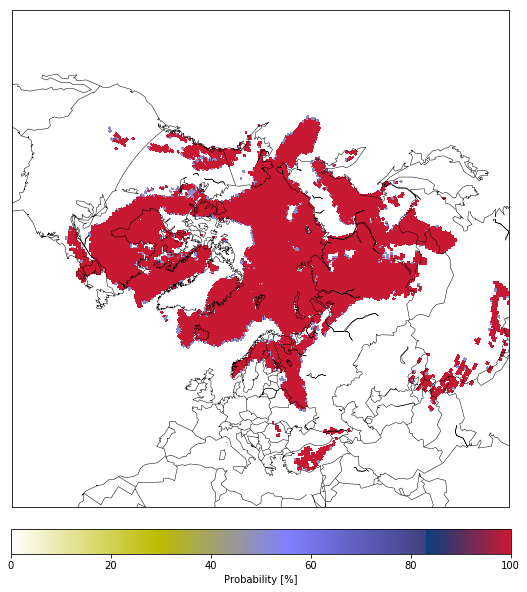

In [62]:
fig = plt.figure(figsize=(10,10))
m = utils.get_projection(projection="nh", labels=False)
# m.shadedrelief(scale=0.4, alpha=0.8)
lon2d, lat2d = np.meshgrid(merged['lon'], merged['lat'])

# Truncate colormap
cmap = plt.get_cmap('gist_stern_r')
new_cmap = utils.truncate_colormap(cmap, 0, 0.9)

# Probabilites plot 
prob_snow=snow.median(axis=0)*100.
prob_snow=np.ma.masked_less_equal(prob_snow, 5)

cs = m.pcolormesh(lon2d, lat2d, prob_snow[10,:,:], vmin=0, vmax=100,
                cmap=new_cmap, latlon=True)

plt.gca().clabel(c, c.levels, inline=True, fmt='%d' , fontsize=10)
plt.colorbar(cs, orientation='horizontal', label='Probability [%]',fraction=0.046, pad=0.04)

In [13]:
cities = ["Minneapolis"]

from geopy.geocoders import Nominatim

t_2m_point={}
t_850hpa_point={}
tot_prec_point={}
snow_point={}
wind_speed_10m_point={}
geolocator = Nominatim()
for city in cities:
    loc = geolocator.geocode(city)
    ilat=np.argmin(abs(lat-loc.latitude))
    ilon=np.argmin(abs(lon-loc.longitude))

    t_2m_point[city] = t_2m[:,:,ilat,ilon].interpolate_na(dim='time')
    t_850hpa_point[city] = t_850hpa[:,:,ilat,ilon].interpolate_na(dim='time')
    tot_prec_point[city] = tot_prec[:,:,ilat,ilon].interpolate_na(dim='time')
    snow_point[city] = snow[:,:,ilat,ilon].interpolate_na(dim='time')
    wind_speed_10m_point[city] = wind_speed_10m[:,:,ilat,ilon].interpolate_na(dim='time')

/home/mpim/m300382/.conda/envs/my_base/lib/python2.7/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [40]:
sns.set(style="white")
#city_to_plot="Roma"
var_to_plot=t_850hpa_point
var2_to_plot=tot_prec_point

for (city_to_plot,latitude,longitude) in cities:
    fig = plt.figure(1, figsize=(9,6))
    plt.plot_date(dtime,var_to_plot[city_to_plot].T,'-',lw=1)
    plt.plot_date(dtime,var_to_plot[city_to_plot].T[:,np.where(n_pert==0)[0]],'-',lw=2.5,color='black')
    plt.ylabel("850 hPa temperature [C]")
    plt.ylim(-25, 20)
    
    plt.gca().minorticks_on()
    plt.gca().grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.gca().grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    
    ax2 = plt.gca().twinx()
    ax2.plot_date(dtime,var2_to_plot[city_to_plot].T,'--',lw=1.5)
    ax2.set_ylabel("Precipitation [mm]")
    ax2.set_ylim(0, 50)
    
    plt.title("GEFS forecast for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))
    fig.autofmt_xdate()
    
    plt.savefig("spaghetti_"+city_to_plot, dpi=150, bbox_inches='tight')
    plt.clf()

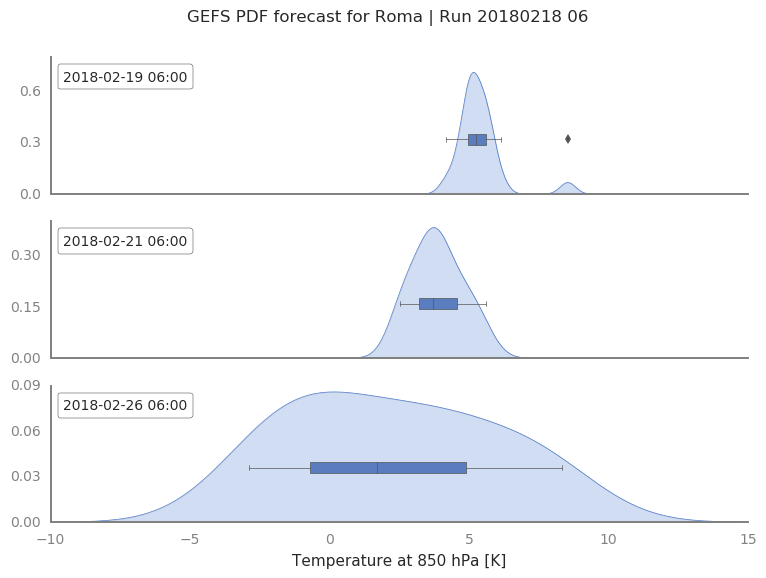

In [377]:
city_to_plot="Roma"
var_to_plot=t_2m_point
myDates= ["2018-02-19 06:00", "2018-02-21 06:00", "2018-02-26 06:00"]

dates = pd.to_datetime(dtime)
df = pd.DataFrame(data=var_to_plot[city_to_plot].T)
df['date']=dates
df = df.set_index(['date'])
df_subset=df.loc[pd.to_datetime(myDates)]

fig = plt.figure(1, figsize=(9, 6))

nrows=np.shape(myDates)[0]
rows=np.arange(start=0, stop=nrows, step=1)
gridspec.GridSpec(nrows,1)

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context(rc={"lines.linewidth": 0.5})
plt.rc_context({'axes.edgecolor':'grey', 'xtick.color':'grey', 'ytick.color':'grey'})
plt.suptitle("GEFS PDF forecast for "+city_to_plot+" | Run "+dtime[0].strftime("%Y%m%d %H"))

for row in rows:
    if row == rows[0]:
        ax1=plt.subplot2grid((nrows,1), (row,0))
    else: 
        plt.subplot2grid((nrows,1), (row,0),sharex=ax1)
    ax2=sns.distplot(df.loc[myDates[row]],hist=False,kde_kws={"shade":True})
    ax3 = ax2.twinx()
    ax3.get_xaxis().set_visible(False)
    sns.boxplot(x=df.loc[myDates[row]],ax=ax3)
    sns.despine()
    ax3.set(ylim=(-4, 6))
    at = AnchoredText(myDates[row], prop=dict(size=10), frameon=True,loc=2)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    plt.gca().add_artist(at)
    ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
    if row != rows[-1]:
        ax2.get_xaxis().set_visible(False)
    else: 
        ax2.get_xaxis().set_visible(True)
        ax2.set_xlabel('Temperature at 850 hPa [C]')

In [22]:
t_2m_new=t_2m.dropna(dim='ens_member')

In [24]:
t_2m.shape

(21, 64, 361, 720)

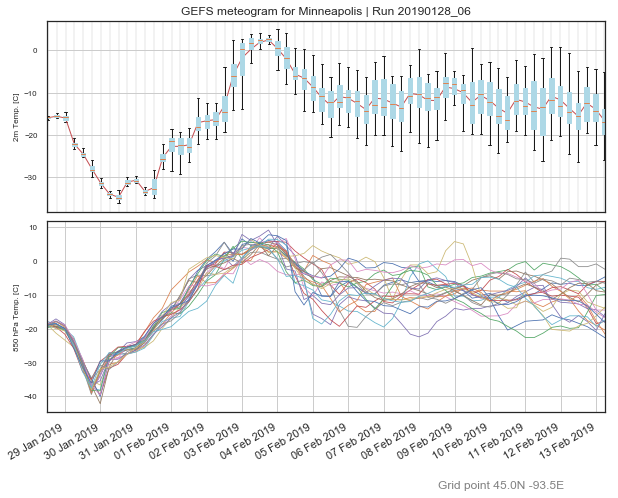

<Figure size 432x288 with 0 Axes>

In [15]:
nrows=2
ncols=1
sns.set(style="white")

for city_to_plot in cities:
    loc = geolocator.geocode(city_to_plot)
    ilat=np.argmin(abs(lat-loc.latitude))
    ilon=np.argmin(abs(lon-loc.longitude))
    
    time=pd.to_datetime(dtime)
    pos = np.array((time-time[0]) / pd.Timedelta('1 hour')).astype("int")

    fig = plt.figure(1, figsize=(10,8))
    ax1=plt.subplot2grid((nrows,ncols), (0,0))
    ax1.set_title("GEFS meteogram for "+city_to_plot+" | Run "+fileslist[0][fileslist[0].find('_2')+1:fileslist[0].find('_00')])
    
    bplot=ax1.boxplot(t_2m_point[city_to_plot].T, patch_artist=True,
                      showfliers=False, positions=pos, widths=3)
    for box in bplot['boxes']:
        box.set(color='LightBlue')
        box.set(facecolor='LightBlue')

    ax1.plot(pos, np.mean(t_2m_point[city_to_plot], axis=0), 'r-', linewidth=1)
    ax1.set_ylabel("2m Temp. [C]",fontsize=8)
    ax1.yaxis.grid(True)
    ax1.xaxis.grid(True, color='gray', linewidth=0.2)
    ax1.tick_params(axis='y', which='major', labelsize=8)
    ax1.tick_params(axis='x', which='both', bottom=False)

#     ax2=plt.subplot2grid((nrows,ncols), (1,0))
#     bplot_rain=ax2.boxplot(tot_prec_point[city_to_plot].T, patch_artist=True,
#                       showfliers=False, positions=pos, widths=3)
#     for box in bplot_rain['boxes']:
#         box.set(color='LightBlue')
#         box.set(facecolor='LightBlue')
        
#     ax2.plot(pos, np.mean(tot_prec_point[city_to_plot], axis=0), 'r-', linewidth=1)
#     ax2.set_ylim(bottom=0)
#     ax2b = ax2.twinx()
#     ax2b.plot(pos, np.mean(snow_point[city_to_plot]*100, axis=0), '*',color='purple')
#     ax2b.set_ylabel("Snow probability",fontsize=8)
#     ax2b.set_ylim(10, 100)
#     ax2.yaxis.grid(True)
#     ax2.set_ylabel("Precipitation [mm]",fontsize=8)
#     ax2.xaxis.grid(True, color='gray', linewidth=0.2)
#     ax2.tick_params(axis='y', which='major', labelsize=8)
#     ax2b.tick_params(axis='y', which='major', labelsize=8)

#     ax3=plt.subplot2grid((nrows,ncols), (2,0))
#     bplot_wind=ax3.boxplot(wind_speed_10m_point[city_to_plot].T, patch_artist=True,
#                       showfliers=False, positions=pos, widths=3)
#     for box in bplot_wind['boxes']:
#         box.set(color='LightBlue')
#         box.set(facecolor='LightBlue')
#     ax3.plot(pos, np.mean(wind_speed_10m_point[city_to_plot], axis=0), 'r-', linewidth=1)

#     ax3.yaxis.grid(True)
#     ax3.set_ylabel("Wind speed [km/h]",fontsize=8)
#     ax3.tick_params(axis='y', which='major', labelsize=8)
#     ax3.set_ylim(bottom=0)
#     ax3.xaxis.grid(True, color='gray', linewidth=0.2)

    ax4=plt.subplot2grid((nrows,ncols), (1,0))
    ax4.plot_date(time, t_850hpa_point[city_to_plot][:,:].T, '-',linewidth=0.8)
    ax4.set_xlim(dtime[0],dtime[-1])
    ax4.set_ylabel("850 hPa Temp. [C]",fontsize=8)
    ax4.tick_params(axis='y', which='major', labelsize=8)
    ax4.yaxis.grid(True)
    ax4.xaxis.grid(True)
    ax4.xaxis.set_major_locator(mdates.DayLocator())
    ax4.xaxis.set_major_formatter(DateFormatter('%d %b %Y'))

    ax4.annotate('Grid point %3.1fN %3.1fE' % (lat[ilat], lon[ilon]), xy=(0.7, -0.4), xycoords='axes fraction', color="gray")

    fig.subplots_adjust(hspace=0.05)
    fig.autofmt_xdate()
    plt.savefig('meteogram_cold.png',dpi=120,bbox_inches='tight')
    plt.show()
    plt.clf()

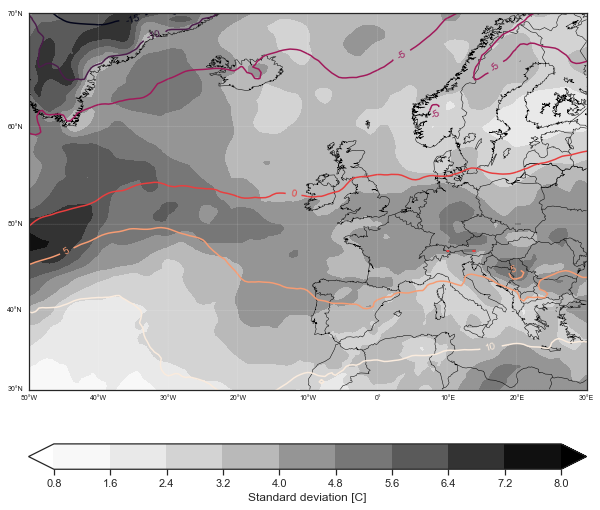

In [111]:
fig = plt.figure(figsize=(10,10))

m = Basemap(projection='mill', llcrnrlon=-50, llcrnrlat=30, urcrnrlon=30, urcrnrlat=70, resolution='l')

# lon2d, lat2d = np.meshgrid(lon, lat)
lon2d, lat2d = np.meshgrid(merged['lon'], merged['lat'])

m.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
m.drawcountries(linewidth=0.5, linestyle='solid', color='black')
m.drawparallels(np.arange(-90.0, 90.0, 10.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7)
m.drawmeridians(np.arange(0.0, 360.0, 10.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7)

levels=(-15, -10, -5, 0, 5, 10)
c = m.contour(lon2d, lat2d, t_850hpa.mean(axis=0)[-1,:,:], extend='both', levels=levels, latlon=True)
cs = m.contourf(lon2d, lat2d, t_850hpa.std(axis=0)[-1,:,:], extend='both', cmap='Greys', latlon=True)

labels=plt.gca().clabel(c, c.levels, inline=True, fmt='%d' , fontsize=10)

plt.colorbar(cs, orientation='horizontal', label='Standard deviation [C]', pad=0.1, fraction=0.05)

plt.show()

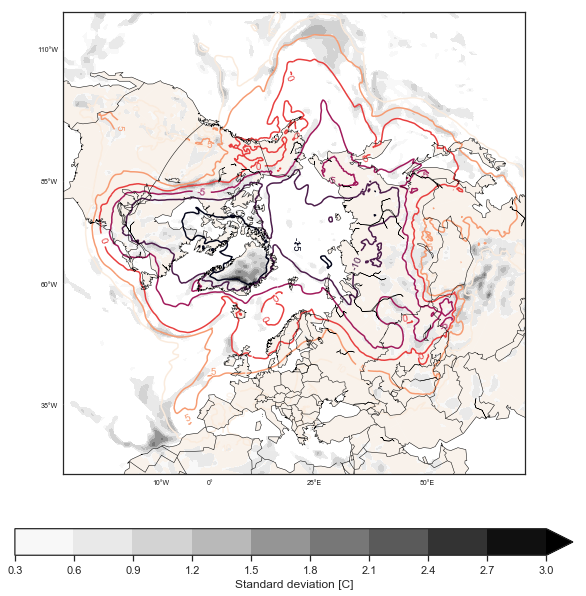

In [144]:
fig = plt.figure(figsize=(10,10))

m = Basemap(projection="npstere", lon_0=20, lat_0=90, boundinglat=30,\
               rsphere=6378160.0, ellps="WGS84",k_0=0.9330127018922193)

# lon2d, lat2d = np.meshgrid(lon, lat)
lon2d, lat2d = np.meshgrid(merged['lon'], merged['lat'])

m.drawcoastlines(linewidth=0.5, linestyle='solid', color='black', zorder=5)
m.drawcountries(linewidth=0.5, linestyle='solid', color='black', zorder=5)
m.drawparallels(np.arange(-90.0, 90.0, 25.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7, zorder=5)
m.drawmeridians(np.arange(0.0, 360.0, 25.), linewidth=0.2, color='white',
                labels=[True, False, False, True], fontsize=7, zorder=5)

m.fillcontinents(zorder=1, color='peru', alpha=0.1)
levels=(-15, -10, -5, 0, 5, 10)
c = m.contour(lon2d, lat2d, t_850hpa.mean(axis=0)[0,:,:], extend='both', levels=levels, latlon=True, zorder=3)
array=t_850hpa.std(axis=0)
array=np.ma.masked_less_equal(array, 0.5)
cs = m.contourf(lon2d, lat2d, array[0,:,:], extend='max', cmap='Greys', latlon=True, zorder=2)

labels=plt.gca().clabel(c, c.levels, inline=True, fmt='%d' , fontsize=10)

plt.colorbar(cs, orientation='horizontal', label='Standard deviation [C]', pad=0.07, fraction=0.04)

plt.show()

<xarray.DataArray 'gh' ()>
array(5985.966309)